```
Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy as sp
import scipy.stats
from collections import defaultdict
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format = 'retina'

Below are basic implementations of a few reverse channel coding schemes:

*   Minimal random coding (Havasi et al., 2019)
*   Ordered random coding (Theis & Yosri, 2022)
*   Poisson functional representation (Li & El Gamal, 2018)
*   Greedy rejection sampling (Harsha et al., 2007)
*   Rejection sampling

The implementations are meant for educational purposes and were not designed for production use or with large-scale experiments in mind.

Where coding schemes normally would depend on an infinite number of candidates samples from a proposal distribution (PFR, GRS, RS), we naively truncate them and return either the best or the last candidate (see also Theis & Yosri, 2022).

In [3]:
def select_rcc(log_scores, method):
  """
  Select a sample using reverse channel coding methods.

  Accepts a MxN matrix of log-density ratios, log p(z_{mn}) / q_m(z_{mn}), where
  q_m is the m-th target distribution and z_{mn} is the n-th candidate. Returns
  an M-dimensional array containing indices of selected candidates.

  Parameters
  ----------
  log_scores: numpy.ndarray
    Logarithm of density ratios

  method: str
    'MRC', 'PFR', or 'ORC'

  Returns
  -------
  numpy.ndarray
    Array of integers representing selected candidates
  """

  M, N = log_scores.shape

  if method == 'MRC':
    log_noise = np.log(-np.log(np.random.rand(M, N)))
  elif method == 'ORC':
    v = N / (N - np.arange(N))
    log_noise = np.log(np.cumsum(-np.log(np.random.rand(M, N)) * v, axis=1))
  elif method == 'PFR':
    log_noise = np.log(np.cumsum(-np.log(np.random.rand(M, N)), axis=1))
  else:
    raise ValueError(f'Unknown method "{method}"')

  return np.argmin(log_scores + log_noise, axis=1)

def select_rs(log_scores, log_score_min):
  """
  Select candidate using rejection sampling.

  Parameters
  ----------
  log_scores: numpy.ndarray
    Logarithm of density ratios

  log_score_min: numpy.ndarray
    Array representing lower bound on log-density ratio, log p(z) / q(z)

  Returns
  -------
  numpy.ndarray
    Indices of selected candidates
  """
  if log_score_min is None:
    log_score_min = np.min(log_scores, axis=1, keepdims=True)

  U = np.random.rand(*log_scores.shape)

  # identify candidates accepted by RS
  row, col = np.where(U < np.exp(log_score_min - log_scores))

  # for each sample, find first accepted candidate
  indices = []
  for i in range(log_scores.shape[0]):
    # skip ahead to sample i
    while len(row) > 0 and row[0] < i:
      row = row[1:]
      col = col[1:]
    if len(row) > 0 and row[0] == i:
      # store index of first acceptable candidate for sample i
      indices.append(col[0])
    else:
      # no acceptable candidate found for sample i
      indices.append(log_scores.shape[1] - 1)
  return indices

def select_candidate(log_scores, method, log_score_min=None):
  """
  Select candidate using one of several methods.
  
  The methods supported by this function are:
    – minimal random coding (Havasi et al., 2019)
    – ordered random coding (Theis & Yosri, 2022)
    – truncated PFR (Li & El Gamal, 2018)
    – rejection sampling

  Parameters
  ----------
  log_scores: numpy.ndarray
    MxN array of log-density ratios, log p(z_{mn}) / q_m(z_{mn})
  
  method: str
    'MRC', 'PFR', 'ORC', or 'RS'

  log_score_min: numpy.ndarray
    Lower bound on log-density ratios

  Returns
  -------
  numpy.ndarray
    Indices of selected candidates
  """

  if method in ['MRC', 'PFR', 'ORC']:
    return select_rcc(log_scores, method)
  elif method == 'RS':
    if log_score_min is None:
      raise ValueError('Please provide `log_score_min`')
    return select_rs(log_scores, log_score_min)
  else:
    raise ValueError(f'Unknown method "{method}""')

def select_harsha(candidates, q, p):
  """
  Select candidate using greedy rejection sampling (Harsha et al., 2007).

  Parameters
  ----------
  candidates: numpy.ndarray
    MxN integer array of candidates

  q: numpy.ndarray
    D-dimensional array of probabilities of target distributions

  p: numpy.ndarray
    D-dimensional array of probabilities of proposal distribution
  
  Returns
  -------
  numpy.ndarray
    M-dimensional array of indices of selected candidates
  """

  M, N = candidates.shape

  # indices of selected candidates
  k = np.zeros(M, dtype=int)

  # accept/reject first candidate
  a = q / p
  accepted = (np.random.rand(M) < a[candidates[:, 0]])

  # probability of each state being picked so far
  q_sofar = p * np.minimum(1, a)

  for j in range(1, N):
    # accept/reject candidate j (if one hasn't been accepted yet)
    Z = (1 - q_sofar.sum()) * p
    a = (q - q_sofar) / Z
    accept = (np.random.rand(M) < a[candidates[:, j]])
    k = np.where(np.logical_and(~accepted, accept), j, k)

    # remember whether a candidate has already been accepted
    accepted = np.logical_or(accepted, accept)

    # update lower bound on q 
    q_sofar = q_sofar + Z * np.minimum(1, a)

  return k

The next cell generates a few random target distributions `q` (which are themselves distributed according to a Dirichlet distribution) and then draws many approximate samples from each using various methods (`methods`) and limits on the number of candidates (`all_n`). The quality of the samples is evaluated in terms of the _total variation divergence_ and _MMD_$^2$. We use the entropy of the selected candidates' index distribution as a proxy for the coding cost.

In [5]:
# number of target distributions sampled
repetitions = 10

# dimensionality of distributions
dim = 8192

# number of samples for each target distribution considered
num_samples = 50000

# maximum number of candidates
num_candidates = int(2 ** 11)

# numbers of candidates evaluated
all_n = 2 ** np.arange(np.log2(num_candidates).astype(int))

# proposal distribution
p = np.ones(dim) / dim

# concentration parameter of Dirichlet distribution over target distributions
alpha = 0.01

# methods to evaluate
methods = ['PFR', 'ORC', 'MRC', 'Harsha', 'RS']

# used to create histograms
bins_samples = np.arange(dim + 1) - 0.5
bins_indices = np.arange(num_candidates + 1) - 0.5

results = {}
for method in methods:
  results[method] = {
    'num_candidates': [],
    'index_hists': [],
    'd_tv': [],
    'd_mmd2': [],
  }

all_kl = []

for r in tqdm(range(repetitions)):
  # pick a random target distribution
  np.random.seed(r)
  q = sp.stats.dirichlet([alpha] * dim).rvs().ravel()
  d_kl = sp.stats.entropy(q, p, base=2)
  all_kl.append(d_kl)
  
  # generate candidates
  candidates = np.random.choice(range(dim), p=p, size=(num_samples, num_candidates))
  
  # negative log-importance weights
  with np.errstate(divide='ignore'):
    log_scores = np.log(p)[candidates] - np.log(q)[candidates]
  
    # used by rejection sampling
    log_score_min = np.min(np.log(p) - np.log(q))
    log_score_offset = 0.0

  for method in methods:
    d_tv = []
    d_mmd2 = []
    index_hists = []
    valid_num_candidates = []
  
    for n in all_n:
      valid_num_candidates.append(n)

      # randomly select one out of n candidates
      if method == 'Harsha':
        indices = select_harsha(candidates[:, :n], q, p)
      else:
        indices = select_candidate(log_scores[:, :n], method, log_score_min - log_score_offset)
      samples = candidates[range(num_samples), indices]
    
      # used later to estimate cost of sample
      index_hist = np.histogram(indices, bins=bins_indices)[0].astype(np.float64)
      index_hist[:n] += 1 / float(n)
      index_hists.append(index_hist)
    
      # measure quality of samples
      q_hat = np.histogram(samples, bins=bins_samples)[0] / float(num_samples)
      d_tv.append(np.sum(np.abs(q - q_hat)) / 2)
      d_mmd2.append(np.sum(q ** 2) + np.sum(q_hat ** 2) - 2 * np.sum(q * q_hat))
  
    results[method]['num_candidates'].append(valid_num_candidates)
    results[method]['index_hists'].append(index_hists)
    results[method]['d_tv'].append(d_tv)
    results[method]['d_mmd2'].append(d_mmd2)

# average results over different target distributions
for method in results:
  # entropy of the marginal index distribution
  hists = np.mean(results[method]['index_hists'], 0)
  results[method]['entropy'] = [
    sp.stats.entropy(hist, base=2) for hist in hists]
  results[method]['d_tv'] = np.mean(results[method]['d_tv'], 0)
  results[method]['d_mmd2'] = np.mean(results[method]['d_mmd2'], 0)

avg_kl = np.mean(all_kl)

100%|██████████| 10/10 [09:25<00:00, 56.60s/it]


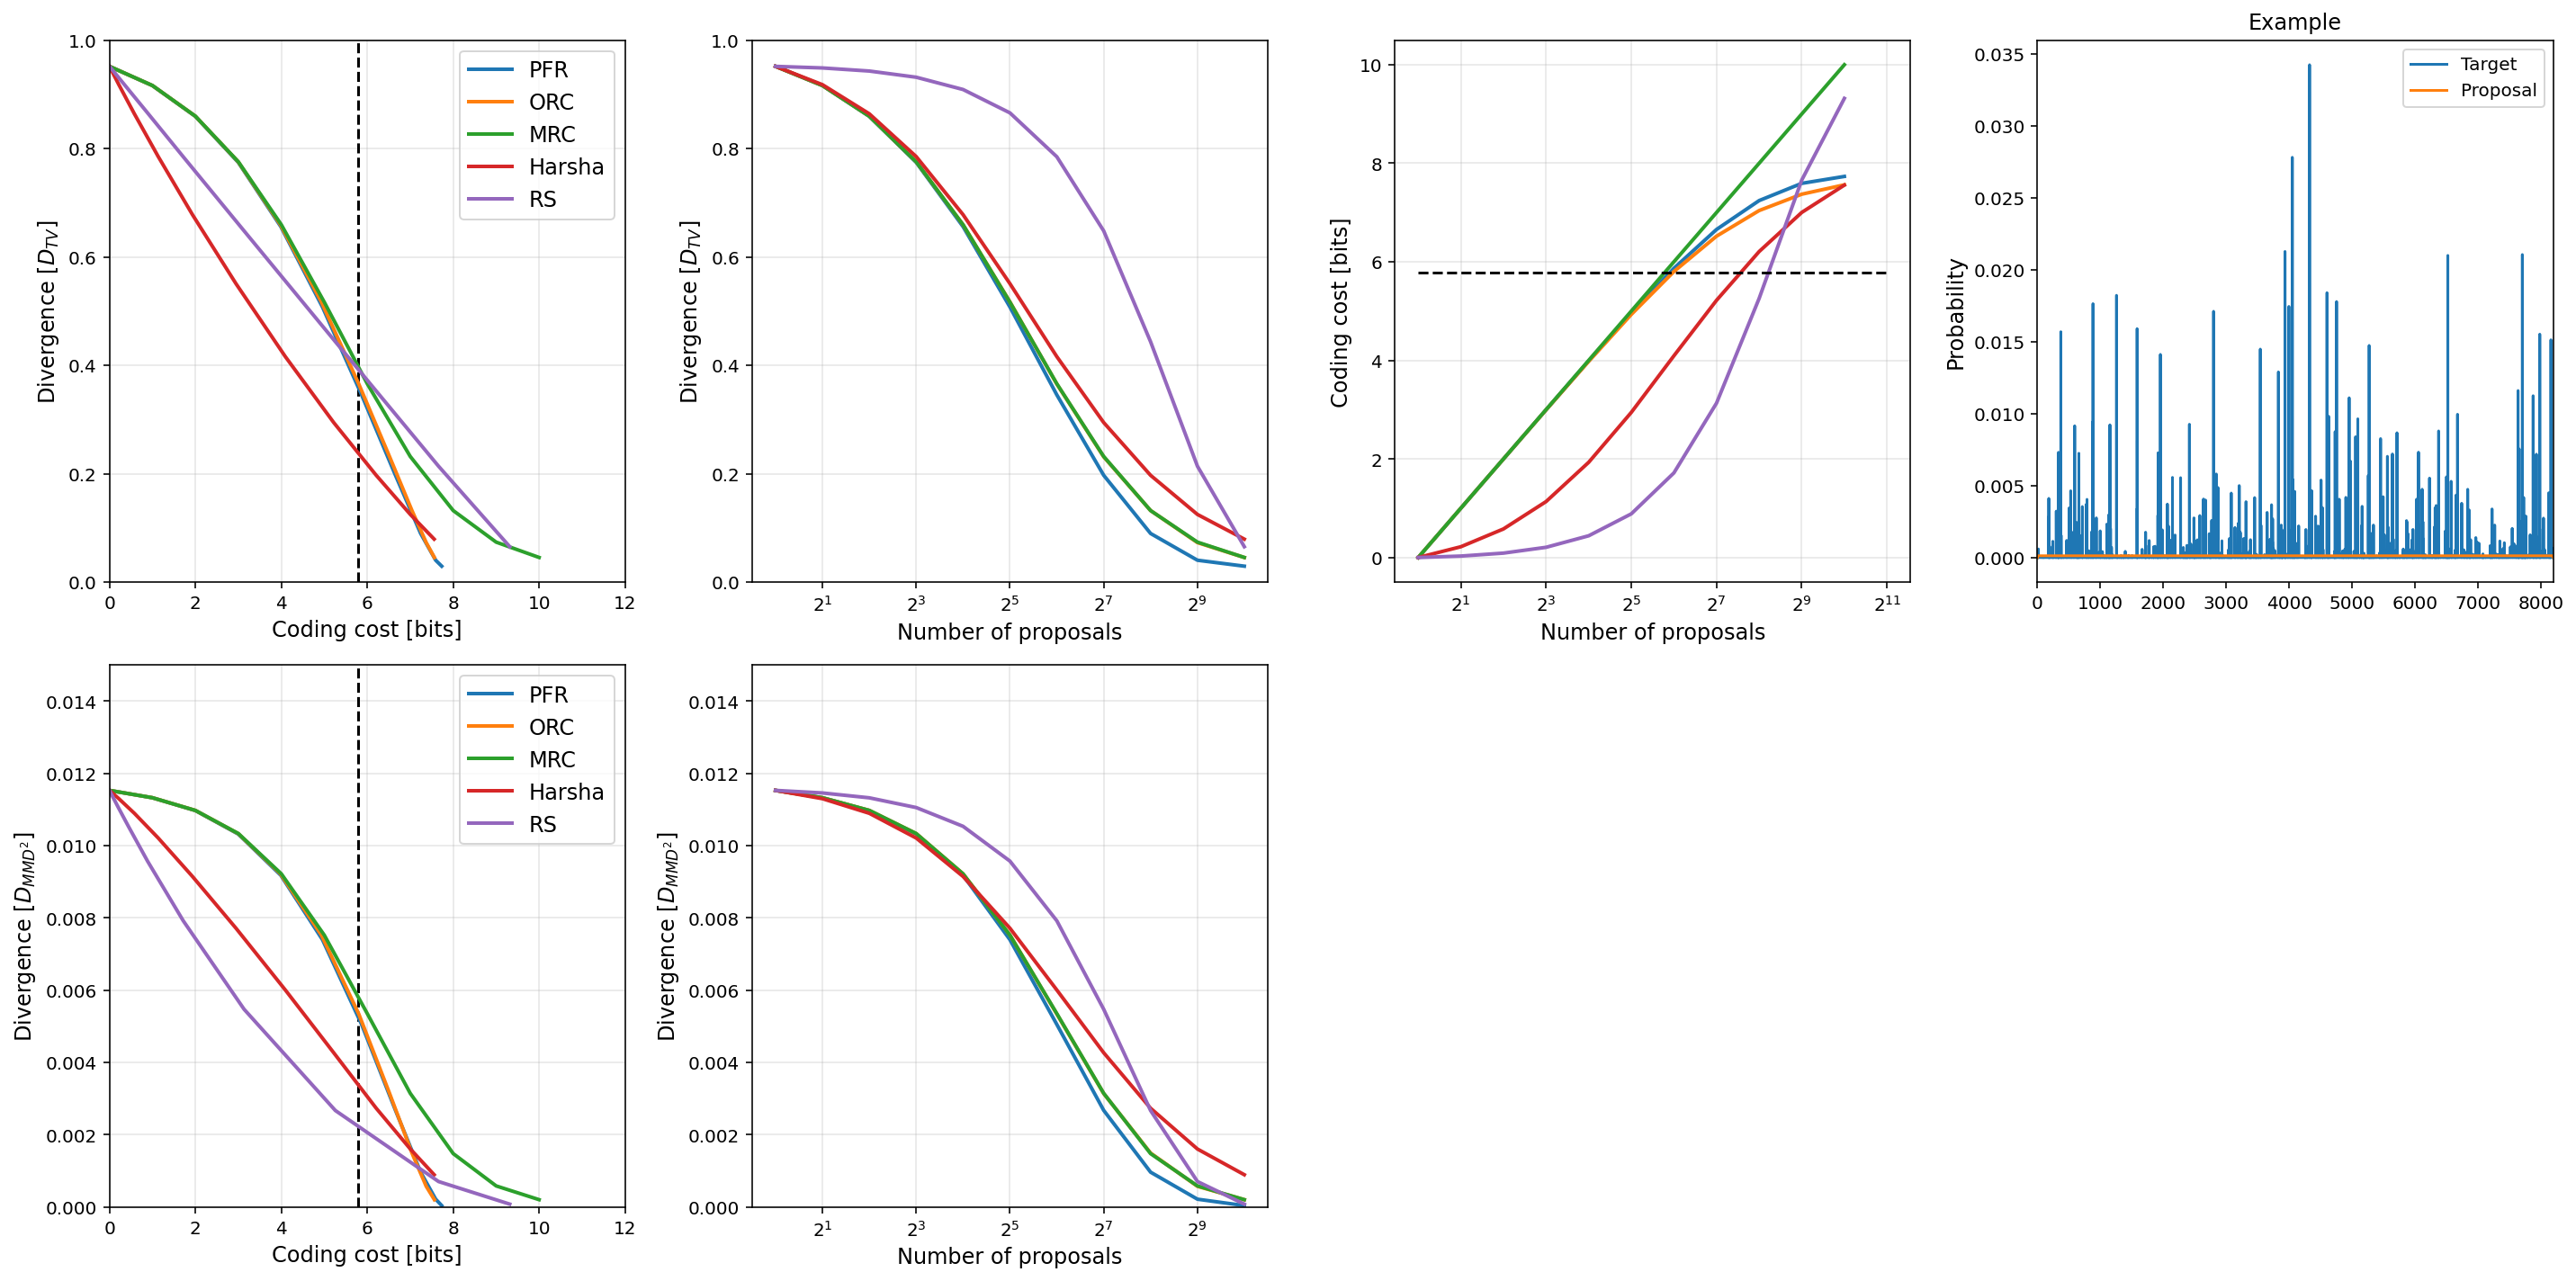

In [7]:
plt.figure(figsize=(20, 10))

fmt = defaultdict(lambda: {})
fmt['LRCC'] = {'marker': '.', 'linestyle': ' ', 'ms': 10}

plt.subplot(2, 4, 1)
plt.plot([avg_kl, avg_kl], [0, 1], 'k--')
for method in results:
  plt.plot(
      results[method]['entropy'],
      results[method]['d_tv'],
      label='IMH' if method == 'Metropolis' else method,
      linewidth=2,
      **fmt[method])
plt.ylim([0, 1])
plt.xlim([0, 12])
plt.xlabel('Coding cost [bits]', fontsize=12)
plt.ylabel('Divergence [$D_{TV}$]', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2, 4, 5)
plt.plot([avg_kl, avg_kl], [0, 1], 'k--')
for method in results:
  plt.plot(
      results[method]['entropy'],
      results[method]['d_mmd2'],
      label='IMH' if method == 'Metropolis' else method,
      linewidth=2,
      **fmt[method])
plt.ylim([0, 0.015])
plt.xlim([0, 12])
plt.xlabel('Coding cost [bits]', fontsize=12)
plt.ylabel('Divergence [$D_{MMD^2}$]', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2, 4, 2)
for method in results:
  plt.semilogx(
      results[method]['num_candidates'][0],
      results[method]['d_tv'],
      label=method,
      linewidth=2,
      base=2,
      **fmt[method])
plt.ylim([0, 1])
plt.xlabel('Number of proposals', fontsize=12)
plt.ylabel('Divergence [$D_{TV}$]', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2, 4, 6)
for method in results:
  plt.semilogx(
      results[method]['num_candidates'][0],
      results[method]['d_mmd2'],
      label=method,
      linewidth=2,
      base=2,
      **fmt[method])
plt.ylim([0, 0.015])
plt.xlabel('Number of proposals', fontsize=12)
plt.ylabel('Divergence [$D_{MMD^2}$]', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2, 4, 3)
for method in results:
  plt.semilogx(
      results[method]['num_candidates'][0],
      results[method]['entropy'],
      label=method,
      linewidth=2,
      base=2,
      **fmt[method])
plt.plot([1, num_candidates], [avg_kl, avg_kl], 'k--')
plt.xlabel('Number of proposals', fontsize=12)
plt.ylabel('Coding cost [bits]', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(2, 4, 4)

x = np.arange(dim + 2) + 0.5
q0 = [0] + list(q) + [0]
p0 = [0] + list(p) + [0]

plt.fill_between(x, q0, step='pre', alpha=0.2)
plt.step(x, q0, label='Target')
plt.fill_between(x, p0, step='pre', alpha=0.2)
plt.step(x, p0, label='Proposal')
plt.legend()
plt.ylabel('Probability', fontsize=12)
plt.title('Example', fontsize=12)
plt.xlim([0, dim + 1])

plt.tight_layout();